In [18]:
import json
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [13]:
def judging_to_csv(judge_type="val_judging"):
    judging_path = Path(os.getcwd()) / f"experiments/experiment_data/composition_experiment/{judge_type}"

    data = []

    for json_file in judging_path.glob("*.json"):
        with open(json_file, 'r') as file:
            content = json.load(file)
        
        header_info = content["HEADER"]
        row_data = header_info.copy()
        
        for key, value in content.items():
            if key != "HEADER":
                row_data[key] = value["asr"]
        data.append(row_data)

    df = pd.DataFrame(data)
    df.fillna(value=pd.NA, inplace=True)

    # Define the path for saving the DataFrame as a CSV
    csv_output_path = Path(os.getcwd()) / "experiments/experiment_data/composition_experiment/csvs"
    csv_output_path.mkdir(parents=True, exist_ok=True)
    csv_file_path = csv_output_path / f"{judge_type}.csv"
    df.to_csv(csv_file_path, index=False)

    return csv_file_path


csv_file_path = judging_to_csv()


In [14]:
df = pd.read_csv(csv_file_path)
# Extract the columns containing ASR values, which are all columns after the first four hyperparameter columns
asr_columns = df.columns[4:]

# Calculate the max, min, mean, std for each row for the ASR columns
df['max_asr'] = df[asr_columns].max(axis=1, skipna=True)
df['min_asr'] = df[asr_columns].min(axis=1, skipna=True)
df['mean_asr'] = df[asr_columns].mean(axis=1, skipna=True)
df['std_asr'] = df[asr_columns].std(axis=1, skipna=True)

# Reorder the columns to place the new stats columns right after the hyperparameter columns
hyperparameter_columns = df.columns[:4]
new_asr_stats_columns = ['max_asr', 'min_asr', 'mean_asr', 'std_asr']
df = df[hyperparameter_columns.tolist() + new_asr_stats_columns + asr_columns.tolist()]

df.to_csv(csv_file_path, index=False)



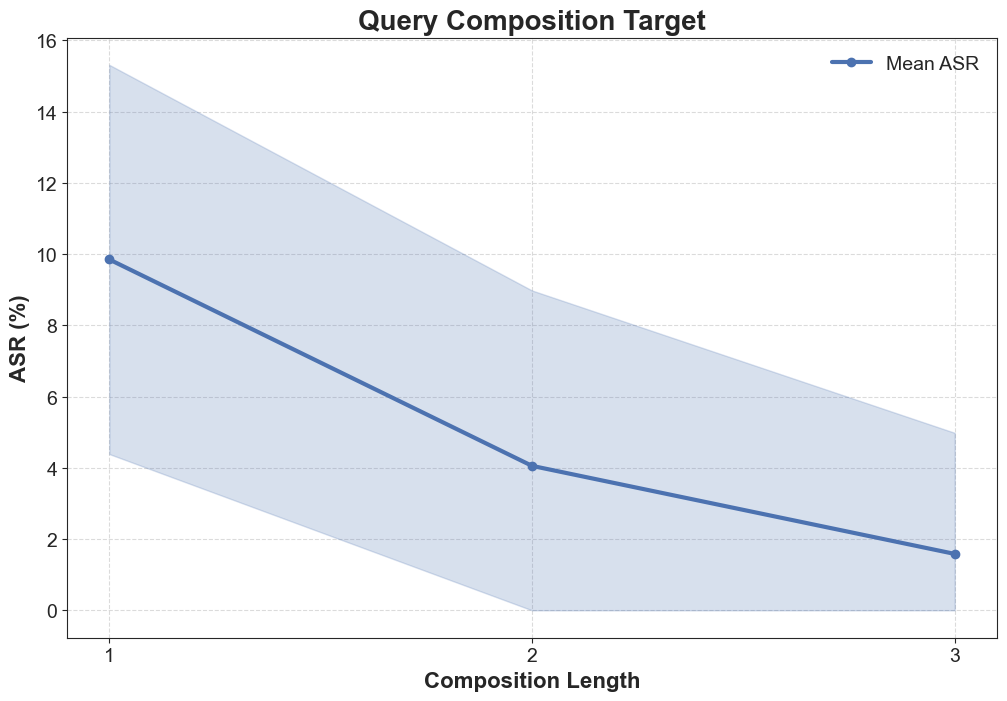

In [38]:
# Group by k_num_transforms and calculate mean and std of all asr columns combined for each group
query_asr_groups = df[df['composition_target'] == 'query'].groupby('k_num_transforms').apply(lambda x: x.iloc[:, 8:].values.flatten())
query_asr_means = query_asr_groups.apply(lambda x: np.nanmean(x))
query_asr_stds = query_asr_groups.apply(lambda x: np.nanstd(x))

import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style
sns.set_style("ticks")
sns.set_palette("muted")

# Create a line plot of the ASR means
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(query_asr_means.index, query_asr_means.values, marker='o', linewidth=3, color='#4C72B0', label='Mean ASR')

# Add a confidence band using the ASR standard deviations
ax.fill_between(query_asr_means.index, np.clip(query_asr_means.values - query_asr_stds.values, 0, None), query_asr_means.values + query_asr_stds.values, alpha=0.22, color='#4C72B0')

# Add labels and title
ax.set_xlabel('Composition Length', fontsize=16, fontweight='bold')
ax.set_ylabel('ASR (%)', fontsize=16, fontweight='bold')
ax.set_title('Query Composition Target', fontsize=20, fontweight='bold')


# Set x-axis ticks to only show integer values
ax.set_xticks(range(1, max(query_asr_means.index) + 1))
ax.tick_params(axis='both', which='major', labelsize=14)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
ax.legend(fontsize=14, frameon=False)

# Adjust the bottom and top margins
plt.subplots_adjust(bottom=0.15, top=0.9)

# Display the plot
plt.show()


In [1]:
from experiments.composition import CompositionExperiment
from models.black_box_model import GPT4_Turbo
from string_transformations.string_transformations import Binary, Id, Leetspeak


hparams = {
    "k_num_transforms": 3,
    "maybe_transformation_instructions": True,
    "other_transform": Leetspeak.construct(),
    "composition_target": "response",
}
target_model = GPT4_Turbo()

ce = CompositionExperiment(target_model=target_model, num_attack_trials=0, hyperparameter_grid={k: [v,] for k, v in hparams.items()})

ce.data_path(**hparams)

/Users/brianhuang/miniconda3/envs/shieldbreak/lib/python3.12/site-packages/tqdm-4.66.2-py3.12.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ltang (crtsn). Use `wandb login --relogin` to force relogin


'b7dc6cf0e2ca487e35a4adf569a4ec4d6cc92b100b104576'